# Conversation with Customized Services

This example will show
- how to create new service functions in AgentScope
- how to incorporate multimodal service functions in AgentScope

We will take langchain tools and dashscope multimodal APIs as example, including:
- langchain tools
- dashscope text-to-image
- dashscope image-to-text
- dashscope text-to-audio

We are working on integrating multimodal service functions into AgentScope, the progress is as follows:

- [🚧] dashscope_text_to_image
- [🚧] dashscope_image_to_text
- [🚧] dashscope_text_to_audio

## Background

AgentScope has built in service toolkit module ([tutorial](https://modelscope.github.io/agentscope/en/tutorial/204-service.html#how-to-use-service-functions), [source code](https://github.com/modelscope/agentscope/blob/cccecb23f56591d859403f86ff0360a5cb4dda1c/src/agentscope/service/service_toolkit.py)) for tools usage, helping developers to integrate service functions into their agents. It provides: 
- format instruction for LLMs
- automatic function description generation in JSON schema format
- LLM response parsing 
- function calling and error handling

The service toolkit module supports all built-in service functions within AgentScope, and developers can also create their own service functions.


## Note

The example is tested with the following models. For other models, some modifications may be needed. 
- gpt-4
- gpt-3.5-turbo 


## Prerequisites

- Install the latest AgentScope from source:

```bash
git clone https://github.com/modelscope/agentscope.git
cd agentscope
pip install -e .
```
- Install [LangChain](https://python.langchain.com/v0.1/docs/get_started/quickstart/) and [DashScope](https://dashscope.aliyun.com/) libraries:

```bash
pip install langchain dashscope pyowm
```

- Fill the next cell to meet the following requirements:
    - OpenWeatherMap API key to experiment with the weather service
    - OpenAI API key
    - DashScope API key

In [22]:
# OpenWeatherMap API key
YOUR_OPENWEATHER_API = "YOUR OPENWEATHER API KEY"

# AgentScope model config
YOUR_MODEL_CONFIGURATION_NAME = "gpt-4"
YOUR_MODEL_CONFIGURATION = {
    "config_name": "gpt-4",
    "model_type": "openai_chat",
    "model_name": "gpt-4",
    "api_key": "YOUR OPENAI API KEY"
}

# DashScope API key
YOUR_API_KEY = "YOUR DASHSCOPE API KEY"

## Implement New Service Functions

Implementing a customized service is as simple as writing a custom function. Just meet the following requirements:

1. Your new service function should return a `ServiceResponse` object, which wraps the execution status and results. It contains two fields: `status` and `content`. 
    - When the Service function runs to completion normally, `status` is `ServiceExecStatus.SUCCESS`, and `content` is the return value of the function. 
    - When an error occurs during execution, `status` is `ServiceExecStatus.Error`, and content contains the error message.

```python
from agentscope.service.service_response import ServiceResponse, ServiceExecStatus

def your_customized_services(argument_1: str, argument_2: int) -> ServiceResponse:
    pass
```

2. Your new service function should provide a well-formatted docstring (Google style is recommended), and the `ServiceToolkit` will automatically parse the docstring and generate description in JSON schema format. 

```python
"""
This function is used to... (a brief description of the function)

Args: 
    argument_1: (`str`): 
        the description of argument_1
    argument_2: (`int`)
        the description of argument_2
"""
```

Then, you can register your function in the `ServiceToolkit` object as follows. Note LLM will be required to specify the not provided argument (e.g. `argument_2` in the following example). 

```python
from agentscope.service import ServiceToolkit

service_toolkit = ServiceToolKit()
service_toolkit.add(your_customize_services, argument_1)
```

---

## Langchain tools
The package of Langchain also offers a variety of tools that may not be covered in  **AgentScope**. You may find a full list of tools supported in Langchain here [Supported Toolkits in Langchain](https://python.langchain.com/v0.1/docs/integrations/tools/)

Let's take the tool `OpenWeatherMap` as an example. `Langchain` provides wrappers for all tool in `.utilities.Wrapper` 

In [23]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper
import os
os.environ['OPENWEATHERMAP_API_KEY'] = YOUR_OPENWEATHER_API
weather = OpenWeatherMapAPIWrapper()
weather_data = weather.run("London,GB")

print(weather_data)

In London,GB, the current weather is as follows:
Detailed status: mist
Wind speed: 1.03 m/s, direction: 0°
Humidity: 93%
Temperature: 
  - Current: 11.75°C
  - High: 12.92°C
  - Low: 10.12°C
  - Feels like: 11.41°C
Rain: {}
Heat index: None
Cloud cover: 100%


We can wrap the call of `Wrapper` into a function to make it available as an `Agentscope` service. 

In [24]:
from agentscope.service.service_response import ServiceResponse
from agentscope.service.service_status import ServiceExecStatus

def get_weather_data(city: str, 
                     country: str, 
                     api_key: str) -> ServiceResponse:
    """Search the weather data of a city

    Args:
        city (`str`): the name of the city.
        country (`str`): the name of the country.
        api_key (str): The api key for the openweathermap api.
    Returns:
        ServiceResponse:  
        A dictionary with two variables: `status` and`content`. 
        If `status` is ServiceExecStatus.SUCCESS, 
        the `content` contains the weather data of the queried city.
    Example: 
        city = "London"
        country = "GB"
        print(get_weather_data(city, country, api_key)) gives:
        In London,GB, the current weather is as follows:
        Detailed status: scattered clouds
        Wind speed: 3.6 m/s, direction: 210°
        Humidity: 85%
        Temperature: 
            - Current: 12.34°C
            - High: 13.08°C
            - Low: 11.39°C
            - Feels like: 11.85°C
        Rain: {}
        Heat index: None
        Cloud cover: 40%
            
    """
    os.environ['OPENWEATHERMAP_API_KEY'] = api_key
    weather = OpenWeatherMapAPIWrapper()
    try:
        weather_data = weather.run(f"{city},{country}")
        return ServiceResponse(ServiceExecStatus.SUCCESS, weather_data)
    except Exception as e:
        return ServiceResponse(ServiceExecStatus.ERROR, str(e))

Now, let's add it to the `ServiceToolKit`. 

In [25]:
from agentscope.service import service_toolkit

toolkit  = service_toolkit.ServiceToolkit()
toolkit.add(get_weather_data, api_key=YOUR_OPENWEATHER_API)

In [26]:
from agentscope.message import Msg
from agentscope.agents import ReActAgent

import agentscope

agentscope.init(
    model_configs=YOUR_MODEL_CONFIGURATION,
    project="Conversation with services"
)

agent = ReActAgent(
    name="assistant",
    model_config_name=YOUR_MODEL_CONFIGURATION_NAME,
    service_toolkit=toolkit, 
    verbose=True # set verbose to True to show  reasoning process
)

msg_question = Msg(
    name="user", 
    content="Which city is better to visit today, London or Paris?", 
    role="user"
)

res = agent(msg_question)

>>> Executing function get_weather_data with arguments:
>>> 	country: UK
>>> 	city: London
>>> END 
>>> Executing function get_weather_data with arguments:
>>> 	country: France
>>> 	city: Paris
>>> END 


In [27]:
print(res.content)

Based on the current weather conditions, both London and Paris seem comfortable for a visit as there is no rain predicted in both cities. However, London might be slightly more pleasant today as it has lighter winds compared to Paris.


Looks Good.

---

## Dashscope

Through flexible and user-friendly model API services, **Dashscope** enables the capabilities of various large AI models to be easily accessible to AI developers. [Click here for a full list of supported models and tasks (in zh-cn)](https://dashscope.console.aliyun.com/model?spm=5176.28630291.0.0.24bf7eb5lzPBes).

The procedure of wraping **Dashscope** as services in **Agentscope** is the same. We need to define a function with clear documentation to call the api. In this section, we implement three services: text-to-image, image-to-text, text-to-audio.

In [28]:
from http import HTTPStatus
import dashscope
import requests

def text_to_image(prompt:str, 
                  api_key:str,
                  number_of_images:int=1,
                  size:str='1024*1024',
                  model:str='wanx-v1') -> ServiceResponse:
    """Generate an image based on a text prompt.

    Args:
        prompt (`str`): the text prompt.
        api_key (`str`): The api key for the dashscope api.
        number_of_images (`int`, defaults to `1`): the number of images to generate. 
        size (`str`, defaults to `1024*1024`): the size of the image.
        model (`str`, defaults to 'wanx-v1'): the model to use.
    Returns:
        ServiceResponse:  
        A dictionary with two variables: `status` and`content`. 
        If `status` is ServiceExecStatus.SUCCESS, 
        the `content` is a dict with key urls and a list of the urls of the generated images.

    Example:
        prompt = "A beautiful sunset in the mountains"
        print(text_to_image(prompt)) gives:
        {'status': 'SUCCESS', 'content': {'urls': ['URL1', 'URL2']}}
    """
    dashscope.api_key = api_key
    response  = dashscope.ImageSynthesis.call(
        model=model,
        prompt=prompt,
        n=number_of_images,
        size=size)
    if response.status_code == HTTPStatus.OK:
        urls = []
        for i, result in enumerate(response.output.results):
            file_name = f"generated_image_{i}.png"
            urls.append(file_name)
            with open('./%s' % file_name, 'wb+') as f:
                f.write(requests.get(result.url).content)
        return ServiceResponse(ServiceExecStatus.SUCCESS, {"urls": urls})
    else:
        err_msg = f"status_code: {response.status_code}, code: {response.code}, message: {response.message}"
        return ServiceResponse(ServiceExecStatus.ERROR, err_msg)

In [29]:
def image_to_text(image_url:str,
                  query_prompt:str, 
                  api_key:str,
                  model:str="qwen-vl-plus") -> ServiceResponse:
    """Generate text based on an image.
    
    Args:
        image_url (`str`): the url of the image.
        query_prompt (`str`): the text prompt.
        api_key (`str`): The api key for the dashscope api.
        model (`str`, defaults to 'qwen-vl-plus'): the model to use.
    Returns:
        ServiceResponse:  
        A dictionary with two variables: `status` and`content`. 
        If `status` is ServiceExecStatus.SUCCESS, 
        the `content` is the generated text.
    Example:
        image_url = "image.jpg"
        query_prompt = "Describe the image"
        print(image_to_text(image_url, query_prompt)) gives:
        {'status': 'SUCCESS', 'content': 'A beautiful sunset in the mountains'}
    """
    dashscope.api_key = api_key
    # get absolute path of the image
    image_path = os.path.abspath(image_url)
    image_url = f"file://{image_path}"
    message = [
        {"role":"user", 
         "content":[
             {"image": image_url},
             {"text": query_prompt}
         ]},
    ]
    response = dashscope.MultiModalConversation.call(model=model, 
                                                     messages=message)
    if response.status_code == HTTPStatus.OK:
        description = response.output.choices[0].message.content[0]['text']
        return ServiceResponse(ServiceExecStatus.SUCCESS, description)
    else:
        err_msg = f"status_code: {response.status_code}, code: {response.code}, message: {response.message}"
        return ServiceResponse(ServiceExecStatus.ERROR, err_msg)    
                  

In [30]:
def text_to_audio(text:str, 
                  api_key:str,
                  model:str='sambert-zhichu-v1',
                  sample_rate:int=48000) -> ServiceResponse:
    """Convert text to audio.
    
    Args:
        text (`str`): the text to convert.
        api_key (`str`): The api key for the dashscope api.
        model (`str`, defaults to 'sambert-zhichu-v1'): the model to use.
        sample_rate (`int`, defaults to 48000): the sample rate of the audio.
    Returns:
        ServiceResponse:  
        A dictionary with two variables: `status` and`content`. 
        If `status` is ServiceExecStatus.SUCCESS, 
        the `content` is the URL of the generated audio file.
    Example:
        text = "How is the weather today?"
        print(text_to_audio(text)) gives:
        {'status': 'SUCCESS', 'content': 'AUDIO_URL'}
    """
    from dashscope.audio.tts import SpeechSynthesizer
    import nest_asyncio
    nest_asyncio.apply()
    dashscope.api_key = api_key
    result = SpeechSynthesizer.call(model=model,
                                                text=text,
                                                sample_rate=sample_rate)
    if result.get_audio_data() is not None:
        with open('output.wav', 'wb') as f:
            f.write(result.get_audio_data())
        return ServiceResponse(ServiceExecStatus.SUCCESS, 'output.wav')
    else:
        return ServiceResponse(ServiceExecStatus.ERROR, "Failed to generate audio file")

In [31]:
toolkit = service_toolkit.ServiceToolkit()


toolkit.add(text_to_image, api_key=YOUR_API_KEY, model="wanx-v1", size="1024*1024")
toolkit.add(image_to_text, api_key=YOUR_API_KEY, model="qwen-vl-plus")
toolkit.add(text_to_audio, api_key=YOUR_API_KEY, model="sambert-zhichu-v1", sample_rate=48000)
agentscope.init(model_configs=YOUR_MODEL_CONFIGURATION)
agent = ReActAgent(
    name="assistant",
    model_config_name=YOUR_MODEL_CONFIGURATION_NAME,
    service_toolkit=toolkit, 
    verbose=True, # set verbose to True to show  reasoning process
)
msg_question = Msg(
    name="user", 
    content=("What's the creature inside the image: image.png" 
             "draw me a picture of the environment of this creature's habitat"
             "and describe the environment in audio"), 
    role="user",
    verbose=True
)
res = agent(msg_question)

>>> Executing function image_to_text with arguments:
>>> 	image_url: image.png
>>> 	query_prompt: What's the creature in the image?
>>> END 
>>> Executing function text_to_image with arguments:
>>> 	prompt: rabbit's natural habitat
>>> 	number_of_images: 1
>>> END 
>>> Executing function text_to_audio with arguments:
>>> 	text: The rabbit's natural habitat includes meadows, woo...
>>> END 


In [32]:
print(res.content)

I have identified the creature as a rabbit. I have generated an image of a typical rabbit's habitat and created an audio description of it.


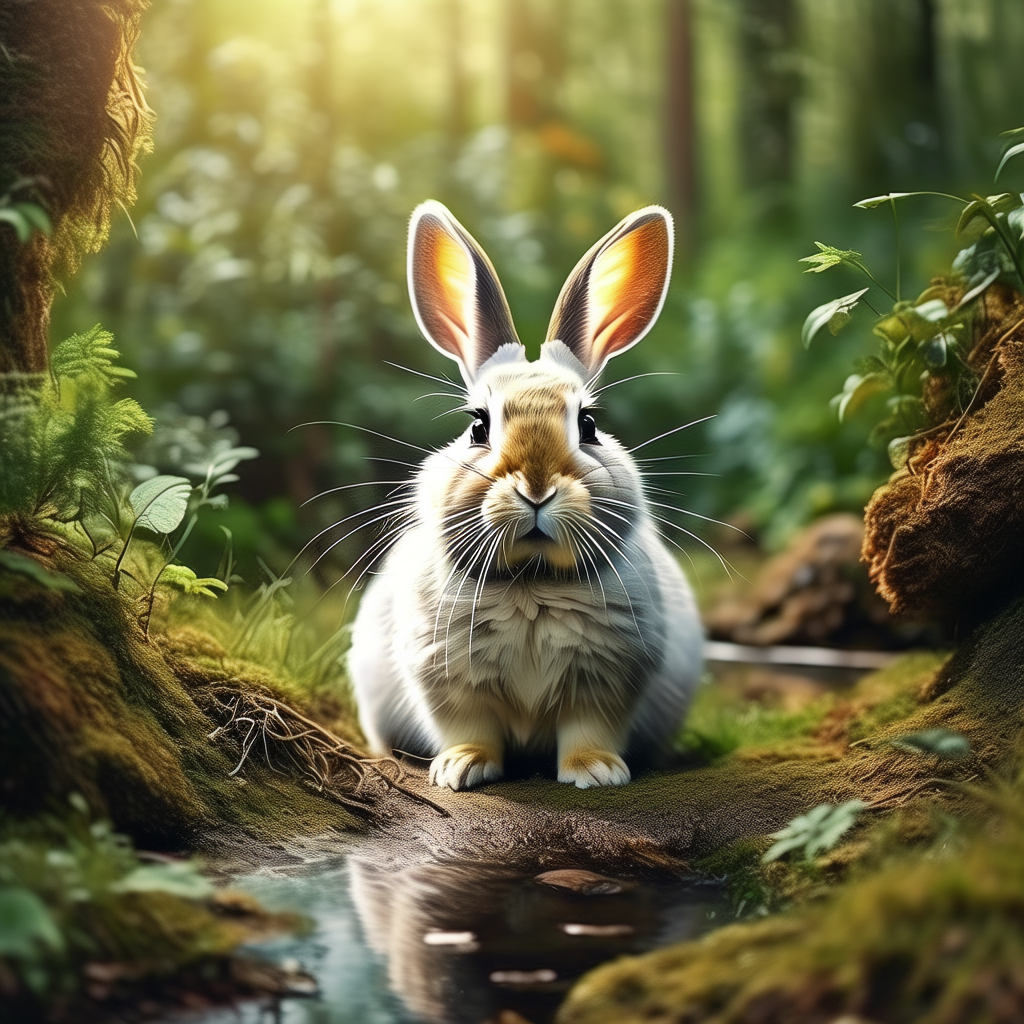

In [33]:
import IPython
# display the generated image
IPython.display.Image("generated_image_0.png")

In [ ]:
IPython.display.Audio("output.wav")